In [ ]:
import csv
import pandas as pd
from tqdm import tqdm
import os
from torch.utils.data import Dataset, DataLoader
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#!pip install torch~=2.2.0 torch_xla[tpu]~=2.2.0 -f https://storage.googleapis.com/libtpu-releases/index.html

In [ ]:
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.distributed.xla_multiprocessing as xmp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!rm -rf /content/data
!cp -r /content/drive/MyDrive/CV_HW_3_3/data /content/data

In [ ]:
labels = ['belly dancing', 'breakdancing', 'country line dancing',
       'dancing ballet', 'dancing charleston', 'dancing gangnam style',
       'dancing macarena', 'jumpstyle dancing', 'mosh pit dancing',
       'robot dancing', 'salsa dancing', 'square dancing',
       'swing dancing', 'tango dancing', 'tap dancing']
label_mapping = {x : idx for idx, x in enumerate(labels)}


In [ ]:
train_csv = pd.read_csv('/content/data/train_annotations.csv', index_col = 0)
val_csv = pd.read_csv('/content/data/val_annotations.csv', index_col = 0)

train_csv['label'] = train_csv['label'].map(label_mapping)
val_csv['label'] = val_csv['label'].map(label_mapping)

train_csv.to_csv('/content/data/train_annotations.csv')
val_csv.to_csv('/content/data/val_annotations.csv')

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the videos.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file, index_col = 0)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
      video_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
      class_label = self.annotations.iloc[idx, 1]

      N_frames = 120

      cap = cv2.VideoCapture(video_path)
      frames = []
      while True:
          ret, frame = cap.read()
          if not ret:
              break
          if self.transform:
              frame = self.transform(frame)
          frames.append(frame)
      cap.release()

      if len(frames) < N_frames:
          while len(frames) < N_frames:
              frames.append(torch.zeros_like(frames[0]))
      elif len(frames) > N_frames:
          frames = frames[:N_frames]

      frames = torch.stack(frames)
      frames = frames.permute(1, 0, 2, 3)

      return frames, class_label



In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VideoDataset(csv_file='/content/data/train_annotations.csv', root_dir='/content/data/train', transform=transform)
val_dataset = VideoDataset(csv_file='/content/data/val_annotations.csv', root_dir='/content/data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)


In [ ]:
class S3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3):
        super(S3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, in_channels, kernel_size=(1, kernel_size, kernel_size),
                               stride=(1, stride, stride), padding=(0, 1, 1), groups=in_channels)
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.conv2 = nn.Conv3d(in_channels, out_channels, kernel_size=(kernel_size, 1, 1),
                               stride=(stride, 1, 1), padding=(1, 0, 0))
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class S3D(nn.Module):
    def __init__(self, num_classes=15):
        super(S3D, self).__init__()
        self.conv1 = S3DBlock(3, 64, stride=2)
        self.pool1 = nn.MaxPool3d((1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.conv2 = S3DBlock(64, 128, stride=2)
        self.conv3 = S3DBlock(128, 256, stride=2)
        self.conv4 = S3DBlock(256, 512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 15
model = S3D(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

# model.to(xm.xla_device())

# xla_train_loader = pl.MpDeviceLoader(train_loader, xm.xla_device())

In [ ]:
accs_train = []
accs_val = []
losses_train = []
losses_val = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for videos, labels in tqdm(train_loader):
        videos = videos.to(device)
        labels = labels.to(device)

        outputs = model(videos)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    losses_train.append(running_loss/len(train_loader))
    accuracy = 100 * correct / total
    accs_val.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}')


    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for videos, labels in tqdm(val_loader):
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    losses_val.append(val_loss)
    accuracy = 100 * correct / total
    accs_val.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [ ]:
import matplotlib.pyplot as plt

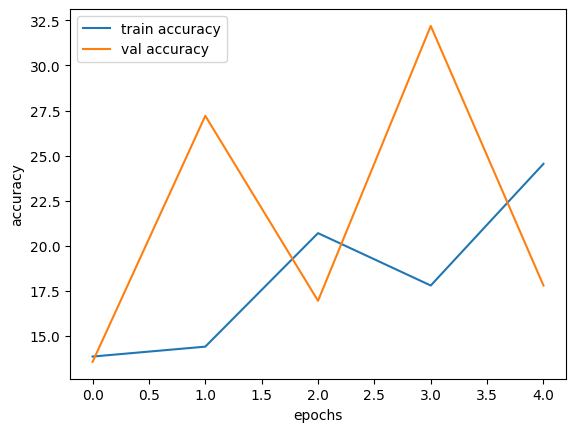

In [ ]:
# вроде растет, не в тот лист добавлял скоры, извиняюсь.
plt.plot(accs_val[:5], label = 'train accuracy')
plt.plot(accs_val[5:], label = 'val accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

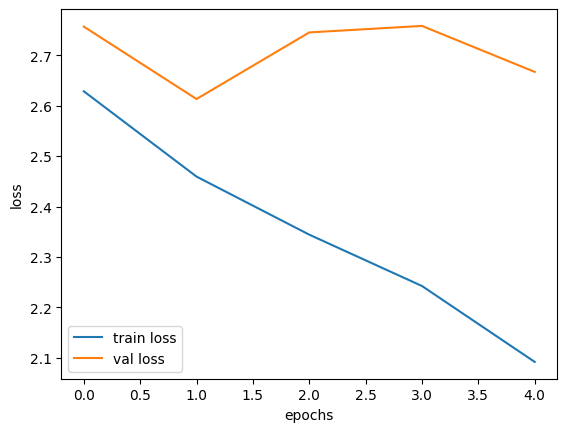

In [ ]:
#вроде падает
plt.plot(losses_train, label = 'train loss')
plt.plot(losses_val, label = 'val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()